# ByoTrack fundamental features

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import byotrack
import byotrack.example_data
import byotrack.visualize

## Loading a video 

In [2]:
# Open an example video
video = byotrack.example_data.hydra_neurons()[130:]  # Let's start at frame 130 where the animal is contracting

# Or provide a path to one of your video
# video = byotrack.Video("path/to/video.ext")

# Or load manually a video as a numpy array
# video = np.random.randn(50, 500, 500, 3)  # T, H, W, C

In [3]:
TEST = True  # Set to False to analyze a whole video

if TEST:
    video = video[:50]  # Temporal slicing to analyze only the first 50 frames

In [4]:
# For video only (With numpy arrays, your are responsible for channels aggregation and normalization)
# A transform can be added to normalize and aggregate channels

transform_config = byotrack.VideoTransformConfig(
    aggregate=True, normalize=True, q_min=0.01, q_max=0.999, smooth_clip=1.0
)
video.set_transform(transform_config)

# Show the min max value used to clip and normalize
print(video._normalizer.mini, video._normalizer.maxi)

[0.] [248.]


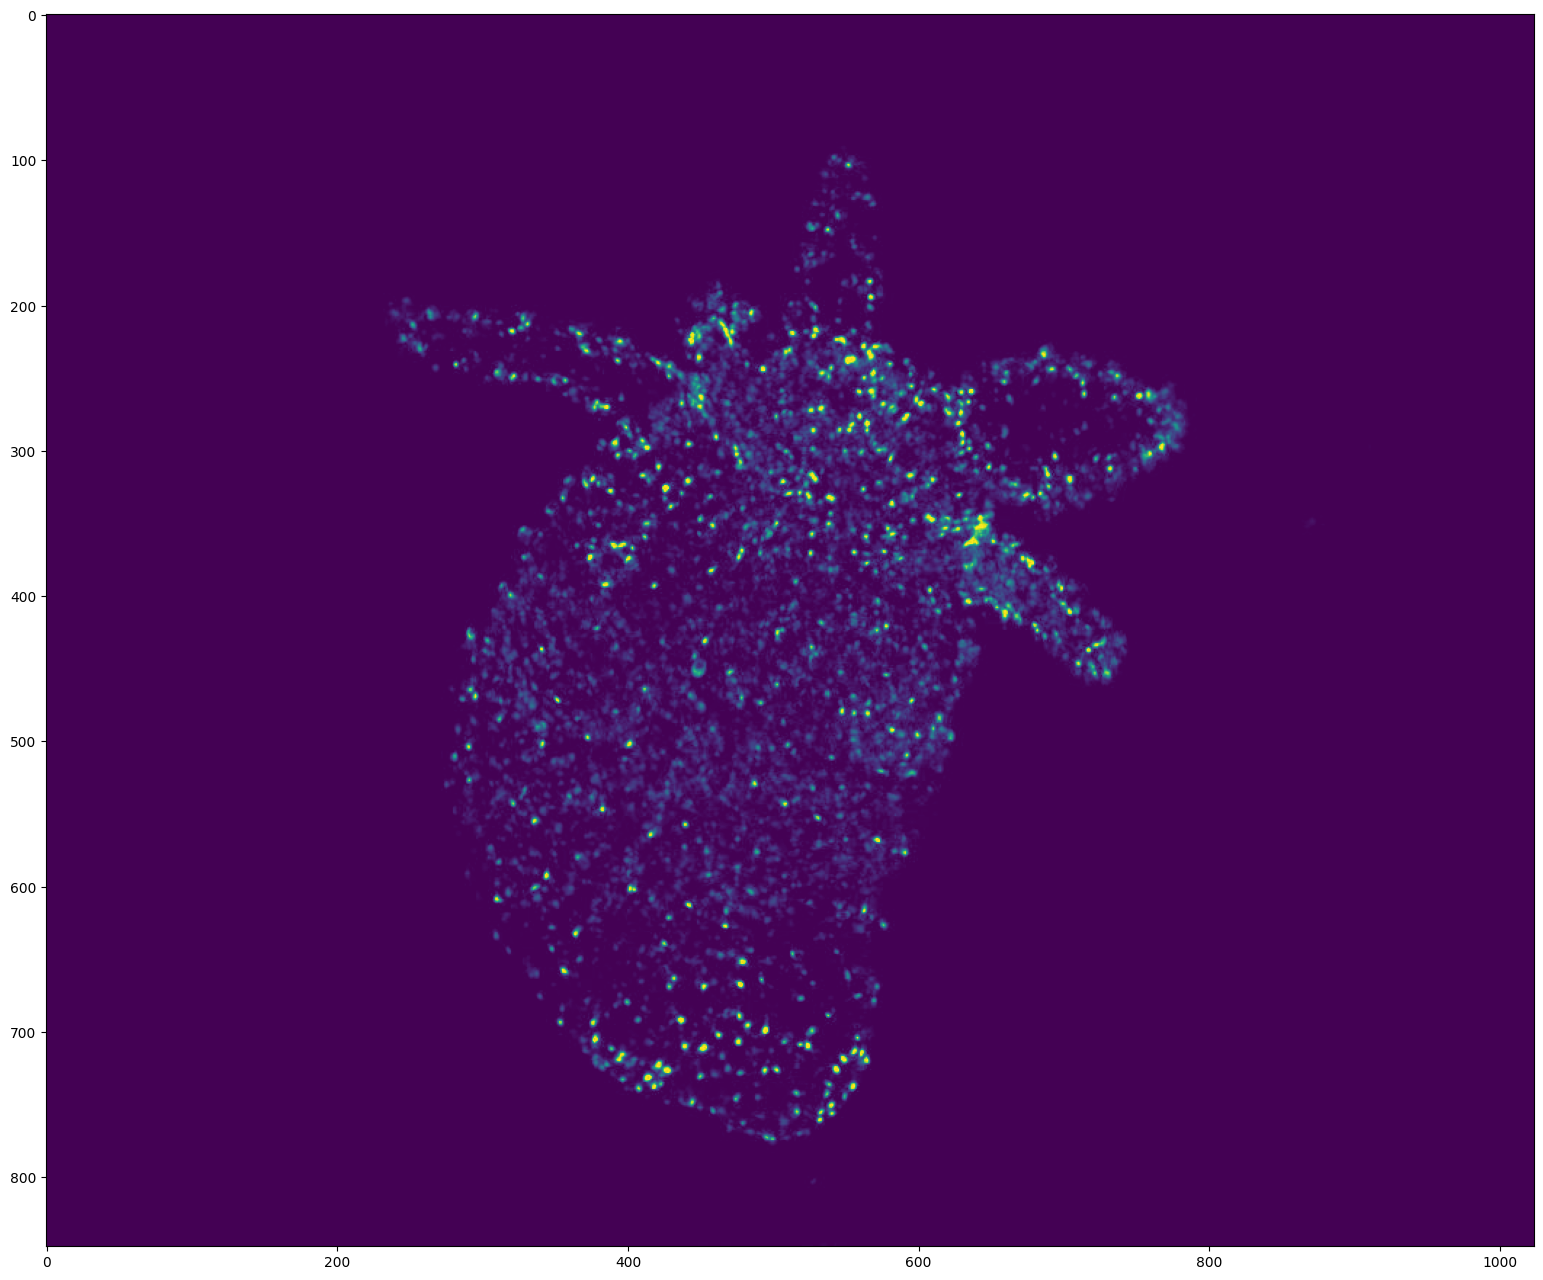

In [5]:
# Display the first frame

frame = video[0]
if  video.ndim == 5:  # (T, D, H, W, C) (3D video)
    frame = frame[frame.shape[0] // 2]  # Show the frame in the middle of the stack

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(frame)
plt.show()

In [6]:
# Display the video with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use b/n to move inside the stack (For 3D videos)
# Use v to switch on/off the display of the video

byotrack.visualize.InteractiveVisualizer(video).run()

## Detections on a video: Example of WaveletDetector

In [7]:
# Create the detector object with its hyper parameters
from byotrack.implementation.detector.wavelet import WaveletDetector

detector = WaveletDetector(scale=1, k=2.5, min_area=5, batch_size=20, device=torch.device("cpu"))

In [8]:
# Run the detection process on the current video

detections_sequence = detector.run(video)

Detections (Wavelet):   0%|          | 0/50 [00:00<?, ?it/s]

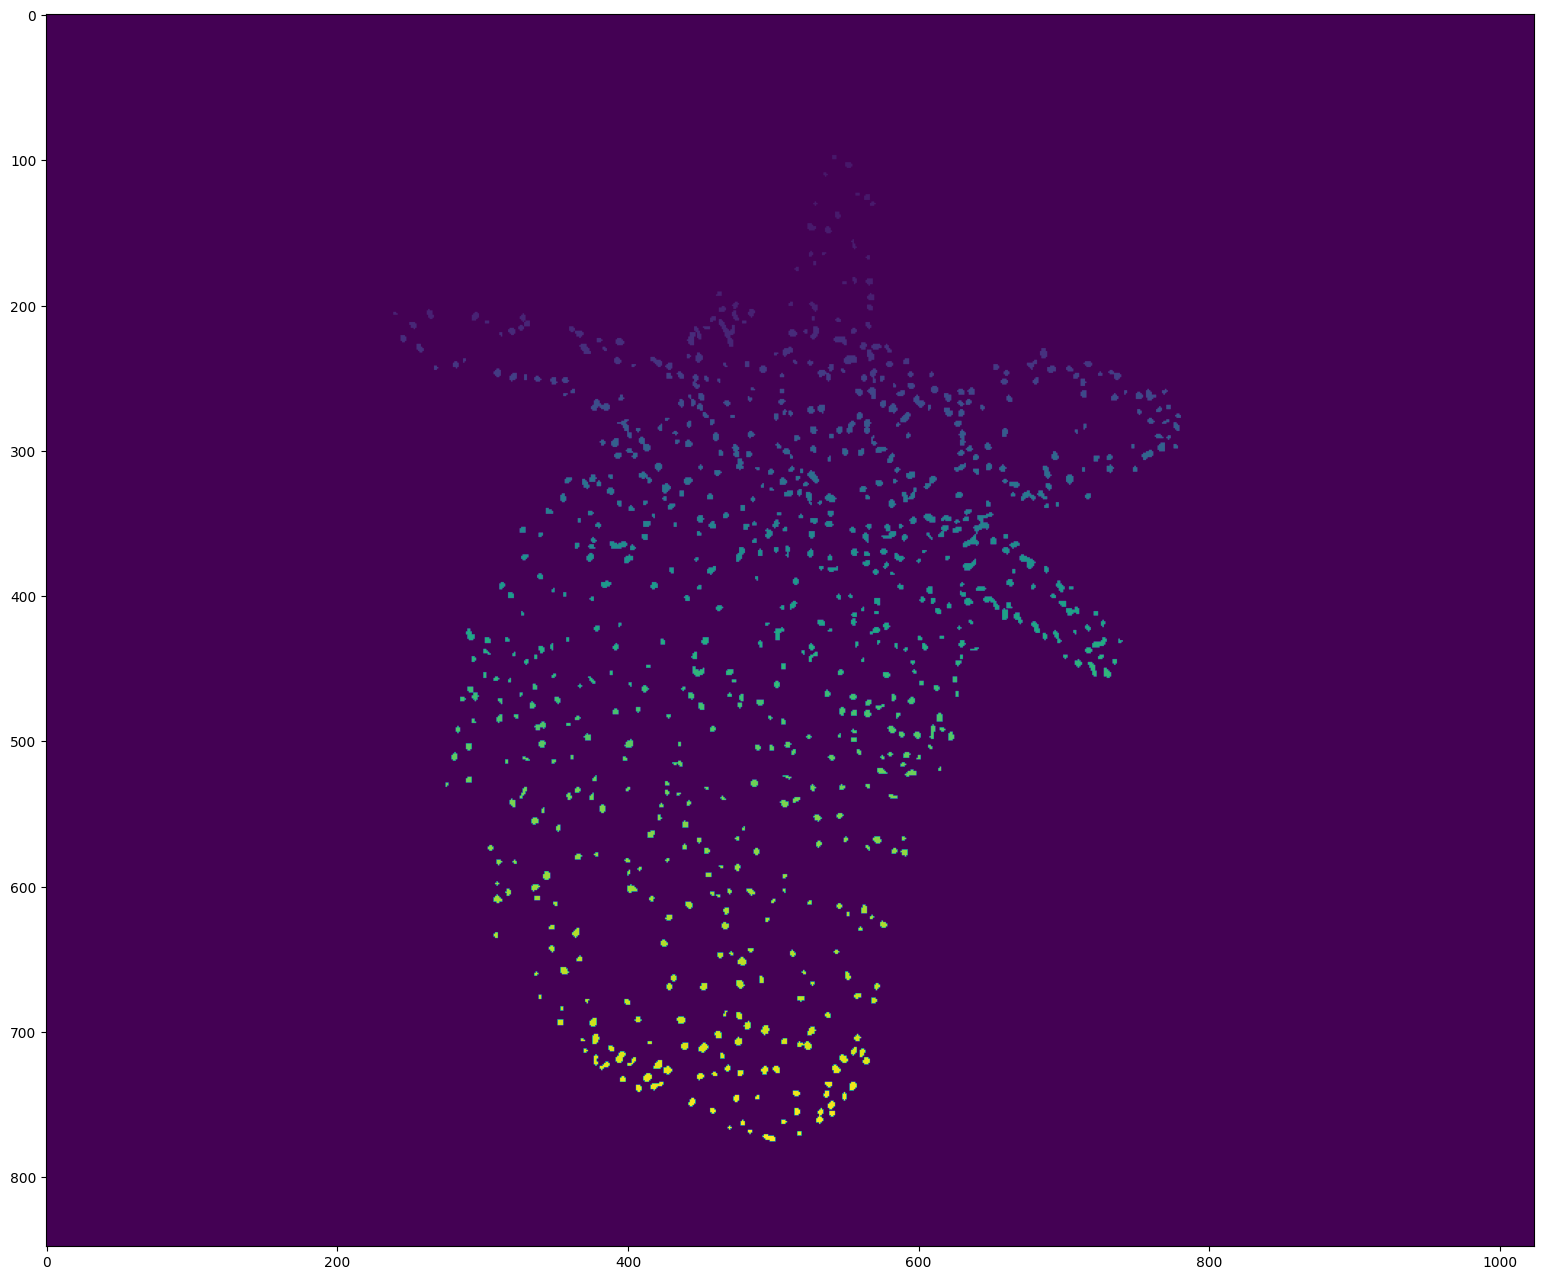

In [9]:
# Display the first detections

segmentation = detections_sequence[0].segmentation

if detections_sequence[0].dim == 3:  # 3D
    segmentation = segmentation[segmentation.shape[0] // 2]  # Show the segmentation in the middle of the stack
    
segmentation = segmentation.clone()
segmentation[segmentation!=0] += 50  # Improve visibility of firsts labels

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(segmentation)
plt.show()

In [10]:
# Display the detections with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use b/n to move inside the stack (For 3D videos)
# Use v to switch on/off the display of the video
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence).run()

In [11]:
# Set hyperparameters manually on the video. (Only works with 2D videos)
# Use w/x to move backward/forward in the video
# Use c/v to update k (the main hyperparameter)
# You can restard with another scale/min_area

K_SPEED = 0.01

i = 0
detector = WaveletDetector(scale=1, k=3.0, min_area=5.0, device=torch.device("cpu"))

while True:
    frame = video[i]
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255

    # Display the resulting frame
    cv2.imshow('Frame', mask)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - k={detector.k} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break

    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)

    if key == ord("c"):
        detector.k = detector.k * (1 - K_SPEED)

    if key == ord("v"):
        detector.k = detector.k * (1 + K_SPEED)


cv2.destroyAllWindows()

## Link detections: Example of KOFTLinker (Kalman and Optical Flow Tracking)

In [12]:
# KOFT requires Optical Flow. We give here the example of Farneback from Open-CV.

from byotrack.implementation.linker.frame_by_frame.koft import KOFTLinker, KOFTLinkerParameters
from byotrack.implementation.optical_flow.opencv import OpenCVOpticalFlow

# Prepare the optical flow algorithm
optflow = OpenCVOpticalFlow(cv2.FarnebackOpticalFlow_create(winSize=20), downscale=4)

# Create the linker
# Look at the documentation (KOFTLinkerParameters?) to see what parameters are available and their full descriptions

specs = KOFTLinkerParameters(
    association_threshold=1e-3,  # Most important parameter: don't link if the association likelihood is smaller than 1e-3.
    detection_std=3.0,  # Detections location are precise up to 3.0 pixels (Usually ~ size of spots)
    process_std=1.5,  # Kalman filter predictions are precise up to 1.5 pixels (Usually ~ size of unmodeled displacement)
    flow_std=1.0,  # Optical flow predictions are precise up to 1.0 pixels/frame
    kalman_order=1,  # Order of the kalman filter (1: Directed, 2: Accelerated, ...)
    n_gap=5,  # Allow to link after 5 consecutive missed detections
    cost="likelihood",  # See koft.Cost? to see which other cost are available, by default it uses Euclidean distance (And association threshod should be express in pixels)
)

linker = KOFTLinker(specs, optflow)

In [13]:
# Before linking, let's check visually that the optical flow algorithm works (Only works with 2D videos)
# We sample a grid of points that are moved by the flow computed.
# The computed flows are good if the points roughly follows the video motion

# Use w/x to move forward in time (or space to run/pause the video)
# Use g to reset the grid of points

byotrack.visualize.InteractiveFlowVisualizer(video, optflow).run()

In [14]:
# Run the linker given a video and detections

tracks = linker.run(video, detections_sequence)

KOFT linking:   0%|          | 0/50 [00:00<?, ?it/s]

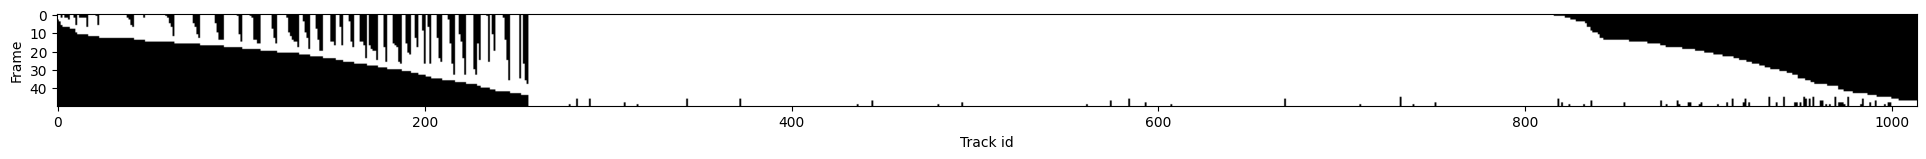

In [15]:
# Visualize track lifetime

# Each track is in white when it alive. (Track on x-axis, time on y-axis)

byotrack.visualize.display_lifetime(tracks)

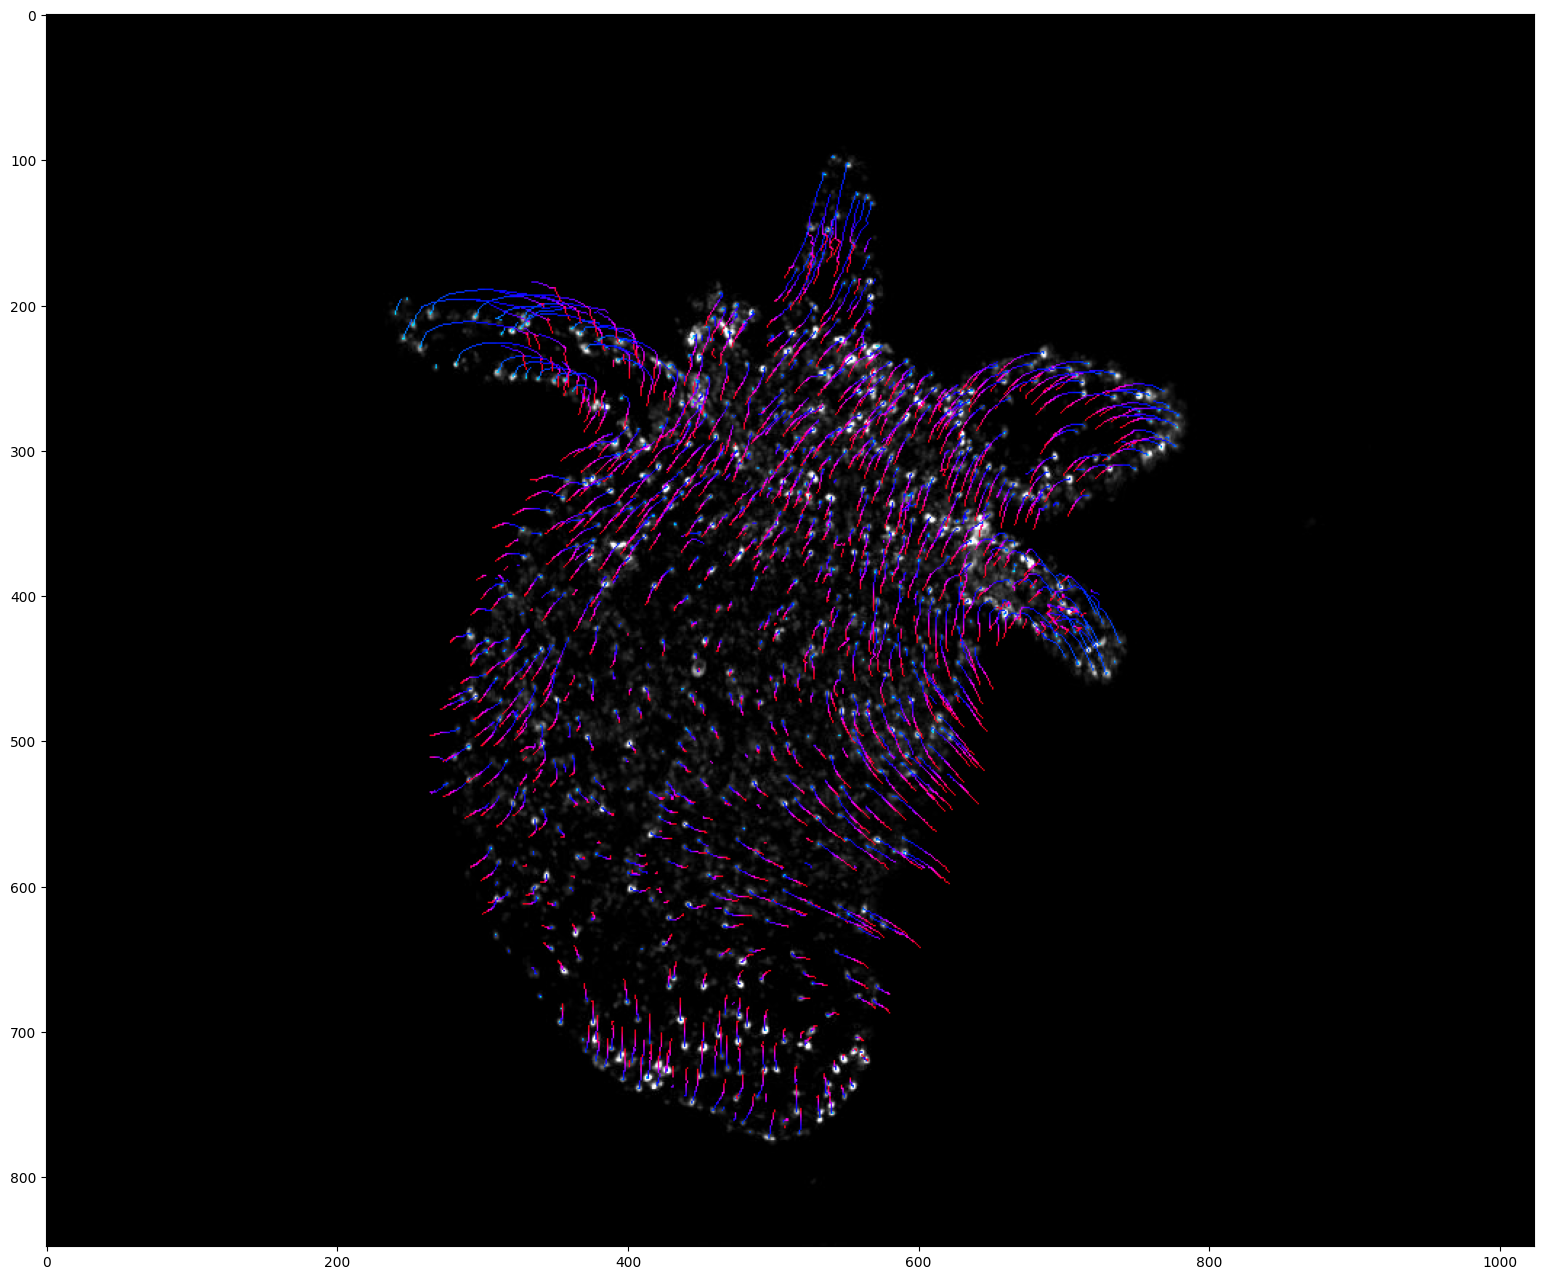

In [16]:
# Project tracks onto a single image and color by time (Only works with 2D videos)

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=video[0],
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

In [17]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use b/n to move inside the stack (For 3D videos)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

## Tracks refinement: Example of Cleaner, followed by EMC2 Stitcher

In [18]:
from byotrack.implementation.refiner.cleaner import Cleaner
from byotrack.implementation.refiner.interpolater import ForwardBackwardInterpolater
from byotrack.implementation.refiner.stitching import EMC2Stitcher

In [19]:
# Split tracks with consecutive dist > 5. Splitting may be counterproductive, check the tracks before applying such cleaner.
# Drop tracks with length < 5

cleaner = Cleaner(min_length=5, max_dist=5.)
tracks = cleaner.run(video, tracks)

Cleaning: Split 99 tracks and dropped 118 resulting ones
Cleaning: From 1014 to 995 tracks


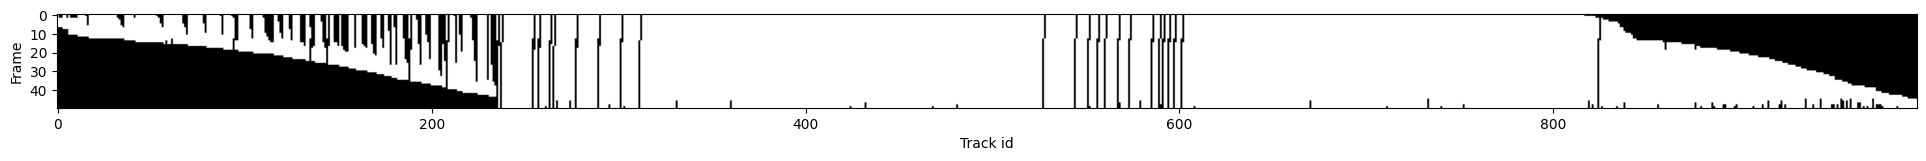

In [20]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

In [21]:
# Stitch tracks together in order to produce coherent track on all the video

stitcher = EMC2Stitcher(eta=5.0)  # Don't link tracks if they are too far (EMC dist > 5 (pixels))
tracks = stitcher.run(video, tracks)

TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

Merging 995 tracks into 950 resulting tracks


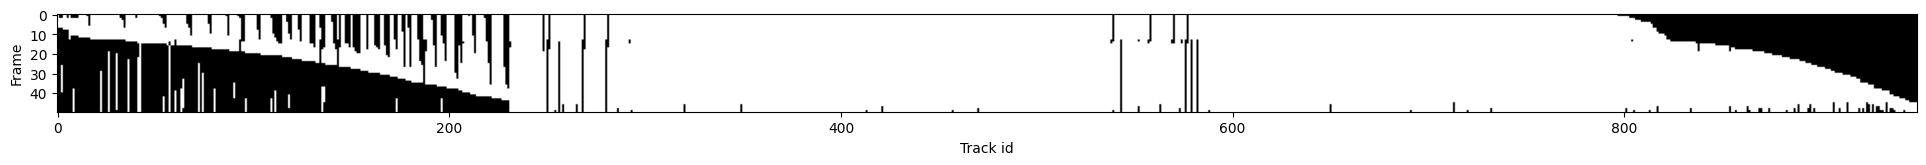

In [22]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

In [23]:
# After EMC2 stitching, NaN values can be inside merged tracks.
# It can be filled with interpolation between known positions

method = "tps"  # tps / constant / flow (You need to provided a valid byotrack.OpticalFlow then)
full = False  # Extrapolate position of the tracks on the all frame range and not just for the track lifespan

interpolater = ForwardBackwardInterpolater(method, full)
tracks = interpolater.run(video, tracks)

TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

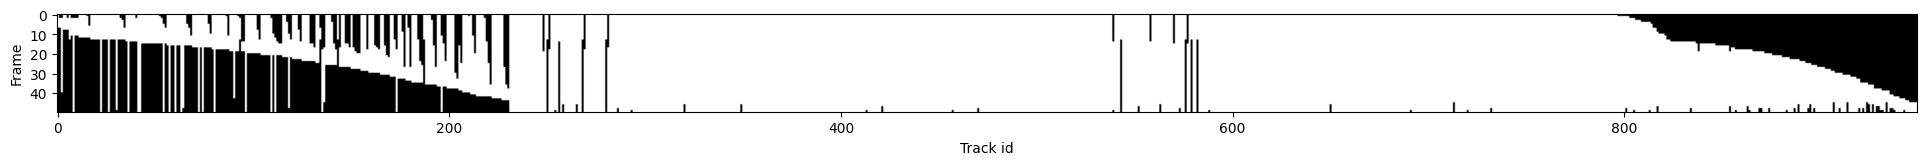

In [24]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

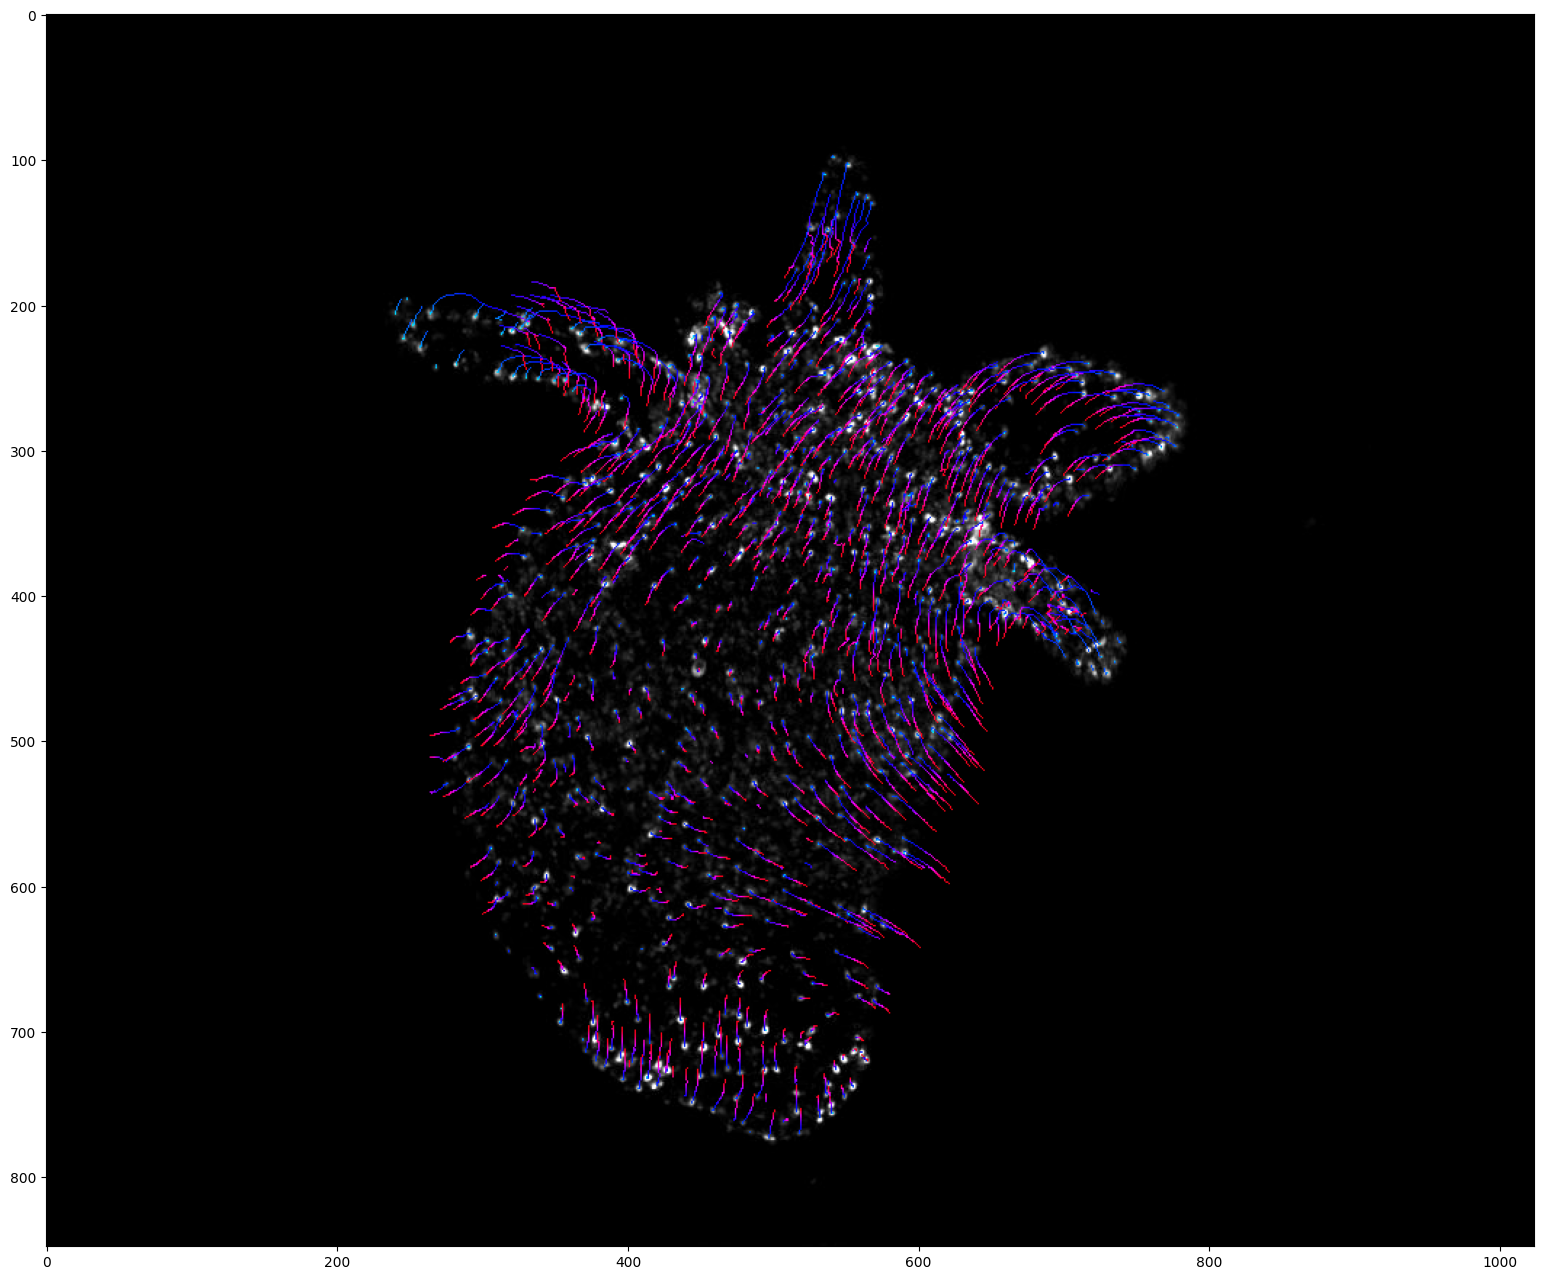

In [25]:
# Project tracks onto a single image and color by time  (Only works with 2D videos)

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=video[0],
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

## End-to-end tracking - Online or Offline tracking

In [26]:
from byotrack import BatchMultiStepTracker, MultiStepTracker

In [27]:
# Create a full tracking pipeline from detector, linker and refiners
# If you have a BatchDetector and a OnlineLinker (True for WaveletDetector and KOFTLinker)
# You may use BatchMultiStepTracker that will process online the video (never keeping all the segmentations in RAM)
# Otherwise, use MultiStepTracker (Run Detections, then linking)

tracker = BatchMultiStepTracker(detector, linker, (cleaner, stitcher, interpolater))
# tracker = MultiStepTracker(detector, linker, (cleaner, stitcher, interpolater))

In [28]:
tracks = tracker.run(video)

Detections (Wavelet):   0%|          | 0/50 [00:00<?, ?it/s]

KOFT linking:   0%|          | 0/50 [00:00<?, ?it/s]

Cleaning: Split 75 tracks and dropped 91 resulting ones
Cleaning: From 862 to 846 tracks


TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

Merging 846 tracks into 803 resulting tracks


TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

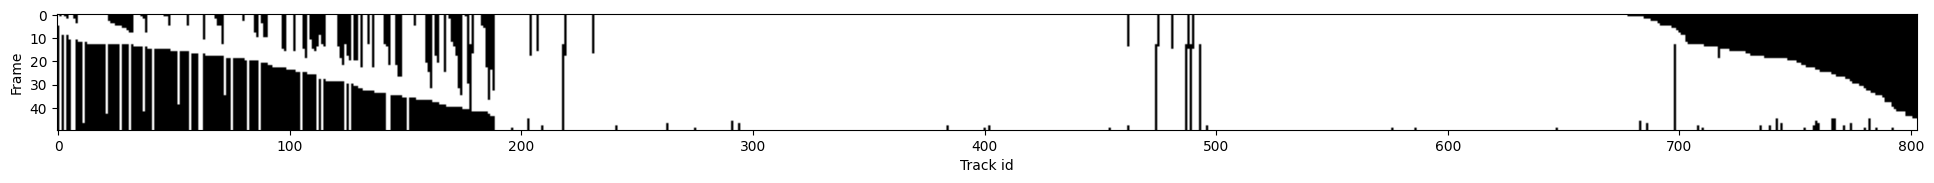

In [29]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

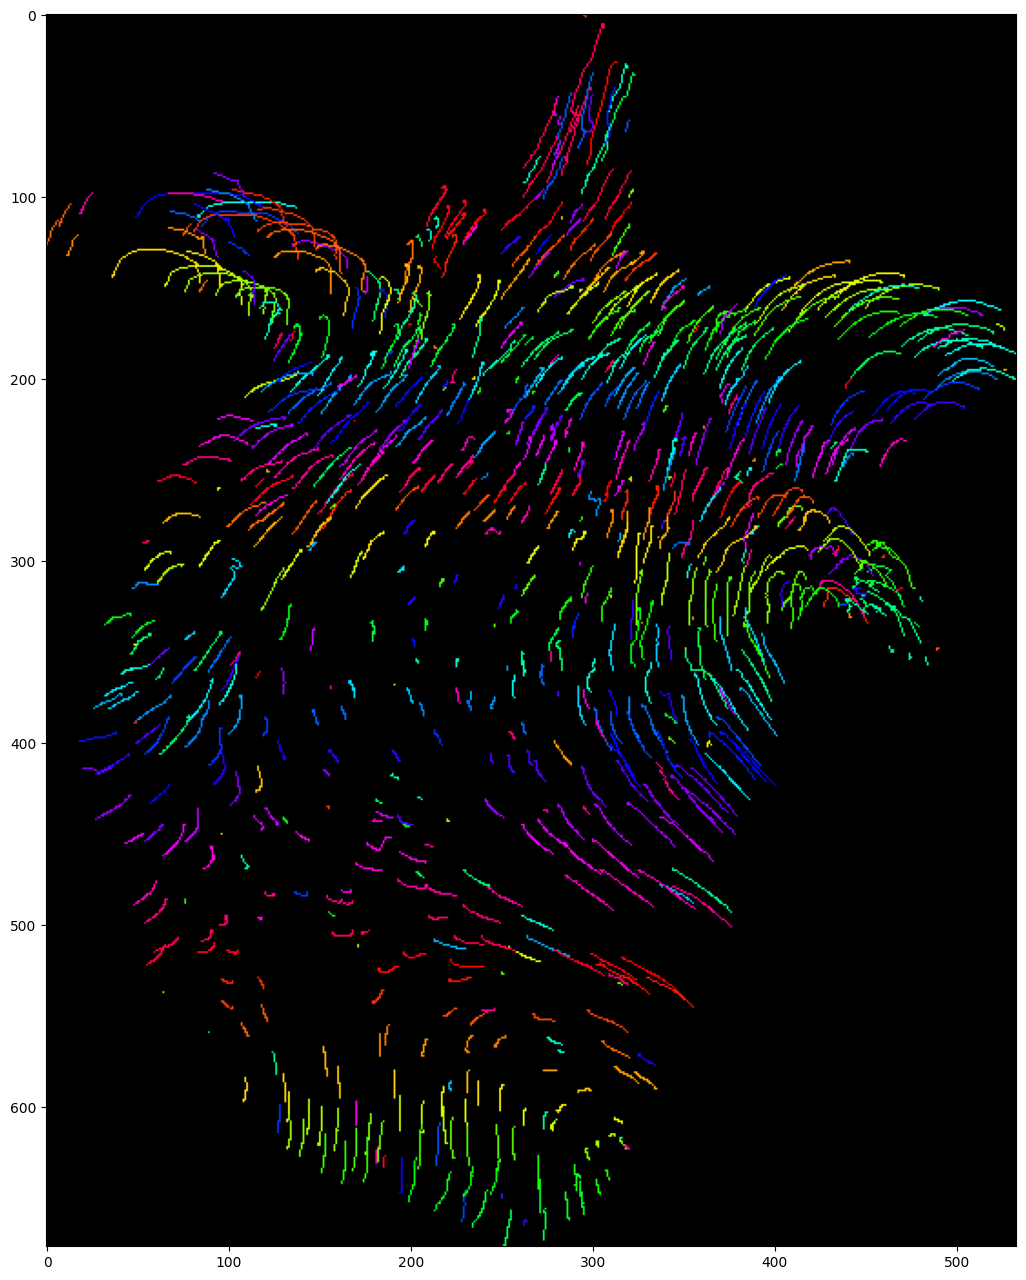

In [30]:
# Project tracks onto a single image and color by track (Only works with 2D videos)

# Create a list of colors for each track (if more tracks than colors, it will cycle through it)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(k / 199)[:3]) for k in range(200)]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

In [31]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use b/n to move inside the stack (For 3D videos)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

## Load or save tracks to files

In [32]:
# Save tracks in ByoTrack format (compressed in a torch tensor)

byotrack.Track.save(tracks, "tracks.pt")

# Can be reload with
tracks = byotrack.Track.load("tracks.pt")

In [33]:
# We also provide IO with Icy software

from byotrack import icy

icy.save_tracks(tracks, "tracks.xml")  # Note that holes should should be filled first with the ForwardBackwardInterpolater

# You can (re)load tracks from icy with
tracks = icy.load_tracks("tracks.xml")